# 3. WORDS EMBEDDINGS

A continuacion vamos a calcular words embeddings con Word2Vec.

## 3.1 Imports y settings previos

In [1]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

In [2]:
import re  # Para Preprocesamiento
import pandas as pd
from time import time  # Tiempo de las operaciones
from collections import defaultdict  # Para Frecuencias de palabras
import multiprocessing
import numpy as np
from sklearn.manifold import TSNE
from gensim.models.word2vec import LineSentence

import spacy  # Para prepocesamiento
import logging  # Configuración de loggings para monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from gensim.models.phrases import Phrases, Phraser

## 3.2 Descarga del corpus

In [3]:
#Nos conectamos a drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/MyDrive/practica_NPL/Software.csv", sep=',')
df.isnull().sum()

overall              0
verified             0
reviewTime           0
reviewerID           0
asin                 0
style             2031
reviewerName         0
reviewText           0
summary              0
unixReviewTime       0
vote              2729
image             3989
dtype: int64

In [5]:
df.dropna(subset=['reviewText'], inplace=True)

In [6]:
df.isnull().sum()

overall              0
verified             0
reviewTime           0
reviewerID           0
asin                 0
style             2031
reviewerName         0
reviewText           0
summary              0
unixReviewTime       0
vote              2729
image             3989
dtype: int64

## 3.3 Preprocesamiento

Pasamos a la limpieza del texto, para ello primeramente creamos la siguiente funcion que usaremos posteriormente:

In [7]:
nlp = spacy.load("en_core_web_sm")
def cleaning(doc):
    # Lematizamos y removemos stopwords
    # doc necesita ser a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec usa las palabras de contexto para aprender a representar el vector de una palabra ,
    # si una sentencia tiene solo una o dos palabras ,
    # el beneficio para el training es muy pequeño
    if len(txt) > 2:
        return ' '.join(txt)

Tambien preparamos otra para quitar los caracteres no alfabeticos

In [8]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['reviewText'])

Utilizamos el atributo .pipe() de spaCy para acelerar la velocidad del proceso de limpieza

In [9]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

print('Tiempo para limpiar todo: {} mins'.format(round((time() - t) / 60, 2)))

Tiempo para limpiar todo: 0.89 mins


Organizamos el resultado en una DataFrame eliminando los valores missing y duplicados:

In [10]:
df_clean_Software = pd.DataFrame({'clean': txt})
df_clean_Software = df_clean_Software.dropna().drop_duplicates()
df_clean_Software.shape

(3672, 1)

guardamos el dataset en csv para poder trabajar en otro momento sin tener que repetir el proceso

In [11]:
df_clean_Software.to_csv('./df_clean_Software.csv')

In [12]:
df_clean_Software.head()

,clean
0,useless io computer ask tech savvy friend help...
1,labor hour turbo tax return finally give disc ...
2,buy software extremely limit font size type ma...
3,junk wull install download frustrating
4,quicken love software strong advocate upgrade ...


In [13]:
df_clean_Software.shape

(3672, 1)

## 3.4 Entrenamiento del modelo

Contamos el numero de nucleos del pc que a posteriori nos resultara util:

In [14]:
cores = multiprocessing.cpu_count() # Contamos el número de cores en el ordenador
print (cores)

2


Inicializamo el Word2Vec:

In [15]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

Construimos el vocabulario

In [16]:
t = time()
sent = [row.split() for row in df_clean_Software['clean']]
w2v_model.build_vocab(sent, progress_per=10000)

print('Tiempo para construir el vocabulario: {} mins'.format(round((time() - t) / 60, 2)))


Tiempo para construir el vocabulario: 0.0 mins


In [17]:
print('Vocabulario compuesto por {} palabras'.format(len(w2v_model.wv.key_to_index)))

Vocabulario compuesto por 1192 palabras


Ahora pasamos al entrenamiento del modelo:

In [18]:
t = time()

w2v_model.train(sent, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)


print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.13 mins


Guardamos el modelo para no tener que repetir el proceso

In [19]:
w2v_model.save('./w2v_model.pkl')

## 3.5 Resultados

In [20]:
w2v_model.wv.most_similar(positive=["problem"])

[('day', 0.9870168566703796),
 ('uninstalle', 0.9866459369659424),
 ('expire', 0.9855982661247253),
 ('symantec', 0.98527991771698),
 ('activate', 0.9837260246276855),
 ('try', 0.9811967015266418),
 ('fix', 0.9781951308250427),
 ('subscription', 0.9754472374916077),
 ('issue', 0.9743232131004333),
 ('refuse', 0.9722554683685303)]

In [21]:
w2v_model.wv.most_similar(positive=["easy"])

[('simple', 0.9794613122940063),
 ('compare', 0.974925696849823),
 ('walk', 0.9724963903427124),
 ('basic', 0.9724584817886353),
 ('relatively', 0.9694530963897705),
 ('complicated', 0.969377875328064),
 ('fairly', 0.9691552519798279),
 ('probably', 0.9687367677688599),
 ('reasonable', 0.9683136343955994),
 ('explanation', 0.9682489633560181)]

In [22]:
w2v_model.wv.most_similar(positive=["window"])

[('vista', 0.988775372505188),
 ('system', 0.9851120114326477),
 ('run', 0.9801815152168274),
 ('xp', 0.9787666201591492),
 ('operating', 0.9758148789405823),
 ('laptop', 0.9733458161354065),
 ('windows', 0.9687224626541138),
 ('machine', 0.9684560894966125),
 ('os', 0.9658236503601074),
 ('boot', 0.9649746417999268)]

In [23]:
w2v_model.wv.similarity('os', 'window')

0.96582365

In [24]:
w2v_model.wv.similarity('complicated', 'bad')

0.90523523

In [27]:
w2v_model.wv.similarity('easy', 'problem')

0.7205008

## 3.6 Visualizacion

Pasamos a la visualizacion, para ello vamos a crear clusteres para 4 palabras las cuales seran problem, easy, window y run

In [34]:
keys = ['problem','easy','window', 'os']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [35]:
print(word_clusters)

[['day', 'uninstalle', 'expire', 'symantec', 'activate', 'try', 'fix', 'subscription', 'issue', 'refuse'], ['simple', 'compare', 'walk', 'basic', 'relatively', 'complicated', 'fairly', 'probably', 'reasonable', 'explanation'], ['vista', 'system', 'run', 'xp', 'operating', 'laptop', 'windows', 'machine', 'os', 'boot'], ['win', 'windows', 'linux', 'operating', 'dell', 'core', 'desktop', 'vista', 'macbook', 'gig']]


Reducimos dimensionalidad a 2D para poder representar:

In [36]:
tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)

In [37]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

In [38]:
embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

Representamos:

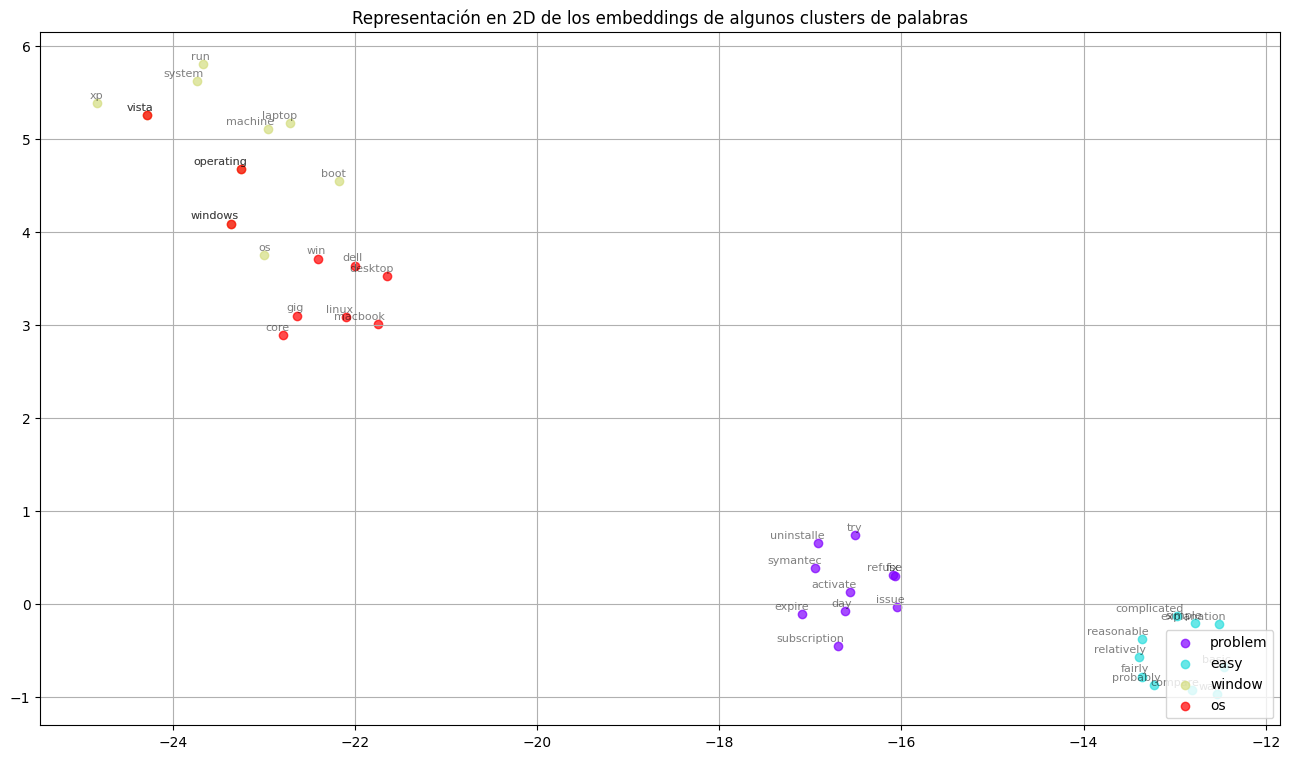

In [39]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline


def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de algunos clusters de palabras')
    # plt.savefig("f/г.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words(keys, embeddings_2d, word_clusters)

## 3.7 Conclusiones

En el apartado 3.5 podemos observar como palabras similares tienen alto porcentaje de similaritud, como os y window(ya que window es un os) y se obtiene un 97%. Por el contrario palabras no similares como easy y problem( porque rara vez vez una persona que tiene un problema lo ve facil) tiene un porcentaje de similaritud bajo un 70%.
En el apartado 3.6 podemos observar graficamente los clusteres de palabras y como palabras similares como son os y window sus clusteres estan unidos y como clusteres de palabras no similares como easy y problem estan separados.
Como conclusion final podemos observar que nuestro modelo funciona correctamente y que hace lo esperado.